In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
#import timeit

import moduli_miguel as mm
from estimators import fit_RIE_CV,fit_Shrinkage_CV,fit_FactorAnalysis_CV,fit_GradientAscentWishart,fit_PCA_CV
from utils import split_train_test, merge_dicts, generate_data_dirichlet

#fa comparire i grafici direttamente sul notebook
%matplotlib inline 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (12,8)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from analyseData import plot2matrices

In [7]:
Ns=1
Ttrain=144
Ttest = int(Ttrain * 20/80)  #small Ttest
alpha=2.
N=116

Xall, Call, Uall, lambdas = generate_data_dirichlet(Ns=Ns, T=Ttrain+Ttest, 
                                                        alpha=alpha, N=N)
Xtrain, Xtest = split_train_test(Xall[0], train_fraction=Ttrain/(Ttrain+Ttest), standardize=True)

thisCtrain = (Xtrain.T @ Xtrain) / Ttrain

In [8]:
result_RIE=fit_RIE_CV(Xtrain,Xtest)

In [9]:
result_shrinkage=fit_Shrinkage_CV(Xtrain,Xtest)

In [10]:
result_PCA=fit_PCA_CV(Xtrain,Xtest)

In [11]:
if True:
    result_SGAW_c=fit_GradientAscentWishart(Xtrain, Xtest, bootstrapping=True, stop='completion',val_frac=0.1)
    result_GAW_c =fit_GradientAscentWishart(Xtrain, Xtest, bootstrapping=False,stop='completion',val_frac=0.1)


In [35]:
if True:
    result_SGAW_l=fit_GradientAscentWishart(Xtrain, Xtest, bootstrapping=True, stop='likelihood',val_frac=0.1)
    result_GAW_l =fit_GradientAscentWishart(Xtrain, Xtest, bootstrapping=False,stop='likelihood',val_frac=0.1)


In [201]:
if False:
    result_FA=fit_FactorAnalysis_CV(Xtrain,Xtest)

In [36]:
print (result_SGAW_c['test_likelihood'],'SGAW_c')
print (result_SGAW_l['test_likelihood'],'SGAW_l')
print (result_GAW_c['test_likelihood'],'GAW_c')
print (result_GAW_l['test_likelihood'],'GAW_l')

print (result_PCA['test_likelihood'],'PCA')
print (result_shrinkage['test_likelihood'],'shrinkage')
print (result_RIE['test_likelihood'],'RIE')

-160.84057860120168 SGAW_c
-160.8348564400057 SGAW_l
-160.90609337758733 GAW_c
-160.90609337758733 GAW_l
-166.29878877653627 PCA
-160.04628461457037 shrinkage
-160.01551533160338 RIE


### explicit test of SGA à la Wishart using the function gradient_ascent_Wishart_multiplier(), not the estimator GradientAscentWishart()

In [31]:
T_GAW=int(0.9*Ttrain)

thisXtrain=np.copy(Xtrain)

Xtrain_GAW = thisXtrain[:T_GAW]
Xval = thisXtrain[T_GAW:]
Ctrain_GAW = Xtrain_GAW.T @ Xtrain_GAW / T_GAW
Yinit = np.eye(N)
B = int(Ttrain*0.25)
maxepochs = 8000

#traces=False 
traces=[]


likelihoods_tr_GAW,likelihoods_te_GAW,completions_te_GAW,steps_GAW,J_GAW = \
                mm.gradient_ascent_Wishart_multiplier(Xtrain_GAW,Ctrain_GAW,maxepochs=maxepochs,eta=1.0E-4,B=B,Y_init=Yinit,\
                                      bootstrapping=True,datate=Xval,stop=False,traces=traces)

C_GAW=np.linalg.inv(J_GAW)

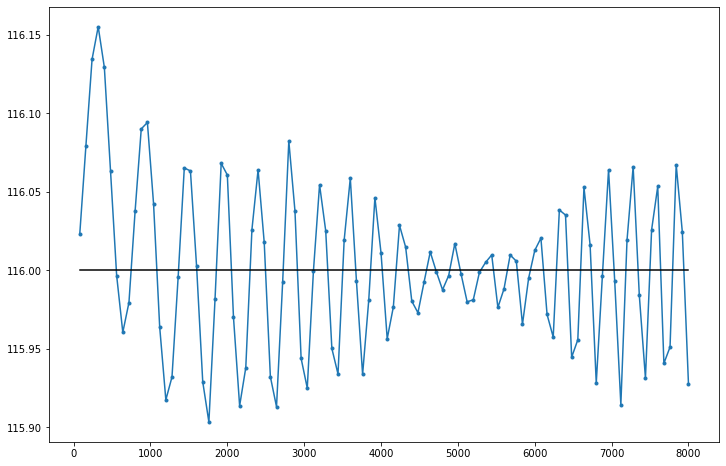

In [32]:
#traces=np.copy(likelihoods_tr_GAW)
if traces!=False:
    plt.plot(steps_GAW,traces,'.-')
    plt.plot(steps_GAW,len(steps_GAW)*[N],'-',color='black')
#plt.savefig('trace_oscillations.pdf')


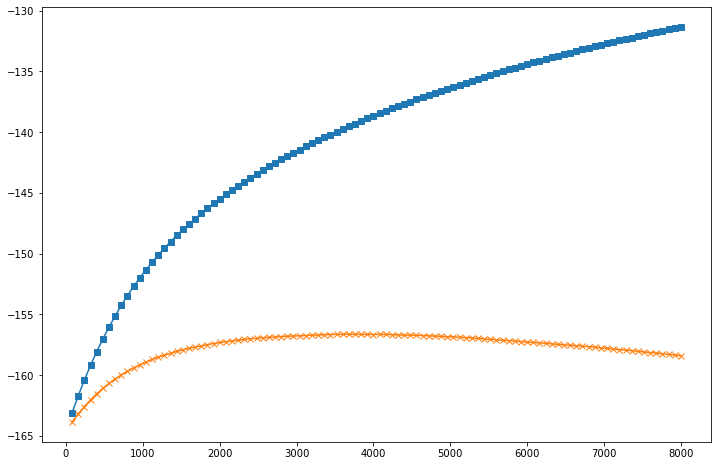

In [33]:
plt.plot(steps_GAW,likelihoods_tr_GAW,'s-')
plt.plot(steps_GAW,likelihoods_te_GAW,'x-')
#plt.plot(steps_GAW,old_likelihoods_tr_GAW,'s-')
#plt.plot(steps_GAW,old_likelihoods_te_GAW,'x-')
plt.show()
#plt.plot(steps_GAW,completions_te_GAW,'x-')

## comparing the spectra: 

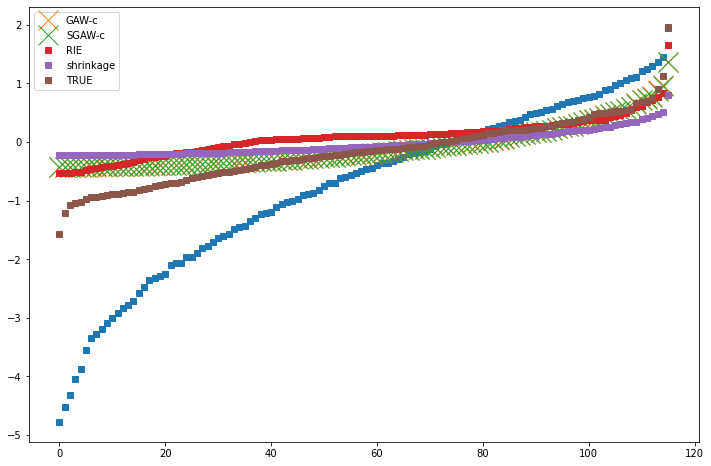

In [139]:
plt.plot(np.log(np.sort(np.linalg.eigvals(thisCtrain))),'s')
#plt.plot(np.log(np.sort(np.linalg.eigvals(C_GAW))),'x',ms=20.,label='GAW')
plt.plot(np.log(np.sort(np.linalg.eigvals(result_GAW_c['Cclean']))),'x',ms=20.,label='GAW-c')
plt.plot(np.log(np.sort(np.linalg.eigvals(result_SGAW_c['Cclean']))),'x',ms=20.,label='SGAW-c')
plt.plot(np.log(np.sort(np.linalg.eigvals(result_RIE['Cclean']))),'s',label='RIE')
plt.plot(np.log(np.sort(np.linalg.eigvals(result_shrinkage['Cclean']))),'s',label='shrinkage')
plt.plot(np.log(np.sort(np.linalg.eigvals(Call[0]))),'s',label='TRUE')
plt.legend()
plt.show()

## comparing with the true C and J matrices: 

In [140]:
Jtrue=np.linalg.inv(Call[0])

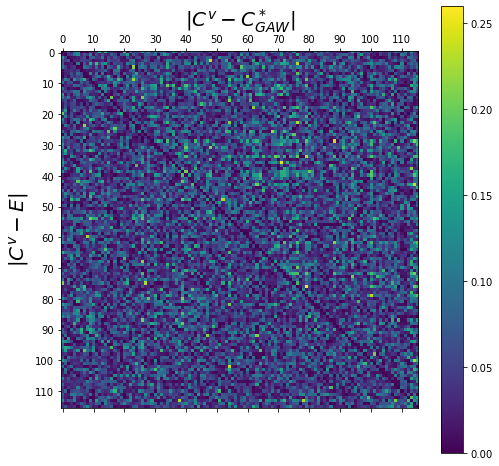

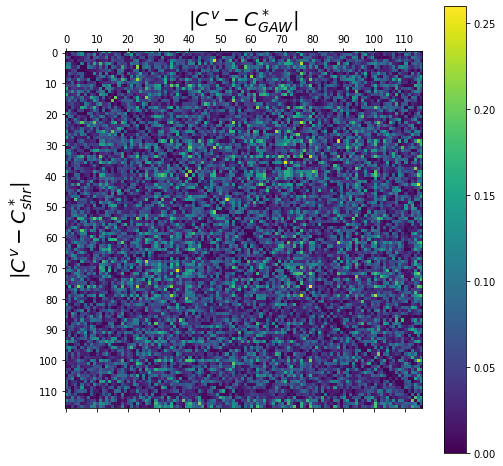

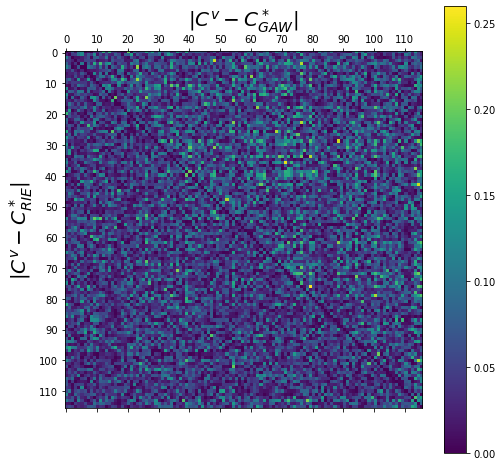

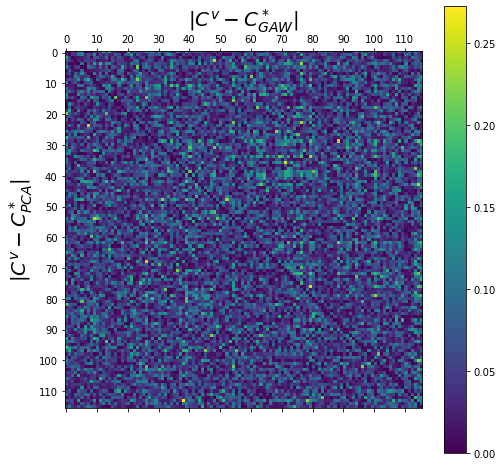

In [189]:
plotCdiffs=True
if plotCdiffs:
    plot2matrices(np.abs(Call[0]-C_GAW),np.abs(Call[0]-thisCtrain),title='$|C^v-C^*_{GAW}|$'\
                      ,ylabel='|$C^{v}-E|$',ticksspacing=10)
    plot2matrices(np.abs(Call[0]-C_GAW),np.abs(Call[0]-result_shrinkage['Cclean'])\
                      ,title='$|C^v-C^*_{GAW}|$',ylabel='$|C^v-C^*_{shr}|$',ticksspacing=10)
    plot2matrices(np.abs(Call[0]-C_GAW),np.abs(Call[0]-result_RIE['Cclean'])\
                      ,title='$|C^v-C^*_{GAW}|$',ylabel='$|C^v-C^*_{RIE}|$',ticksspacing=10)

    plot2matrices(np.abs(Call[0]-C_GAW),np.abs(Call[0]-result_PCA['Cclean'])\
                      ,title='$|C^v-C^*_{GAW}|$',ylabel='$|C^v-C^*_{PCA}|$',ticksspacing=10)


In [142]:
plotJdiffs=False
if plotJdiffs:
    plot2matrices(np.abs(Jtrue-np.linalg.inv(thisCtrain)),np.abs(Jtrue-J_GAW),title='|$J^{v}-E^{-1}|$'\
                      ,ylabel='$|J^v-J^*_{GAW}|$')

    plot2matrices(np.abs(Jtrue-J_GAW),np.abs(Jtrue-np.linalg.inv(result_shrinkage['Cclean']))\
                      ,title='$|J^v-J^*_{GAW}|$',ylabel='$|J^v-J^*_{shr}|$')

    plot2matrices(np.abs(Jtrue-np.linalg.inv(result_RIE['Cclean'])),np.abs(Jtrue-J_GAW)\
                      ,title='$|J^v-J^*_{RIE}|$',ylabel='$|J^v-J^*_{GAW}|$')

